# making an aggregate master dataframe for baseline model  10/22/18 -11/6/18
this notebook is going to make standardized longformat dataframes for each dataframe that i will adjust for each model to. 

for my first pass, i will work to establish a baseline model by using:
the single "worst", or value that most indicates poor clinical outcomes, for each variable so each variable only has one row per patient. 


- make a long format table(ie variable, patient, time, value)
 - step1:Standardize all columns, format, etc. 
 - step2: Maybe make a long format table for each dataframe
 - step3: Impute
 
- combine features from each long table for 1 wide table (ie each patient has a row, each parameter has a column). 
 - feature select for "Clinical worst case" 



- Establish a baseline (ie train model initially), using an obvious baseline: last valid mesurement of a particular variable.   Will hope that it doesn’t perform too good or too bad. Second would be to pick an aggregate within a time window (over 3 days, or of each day, ie can change graunlarity).

- Next try temporal trend, maybe vector autoregression. 

So my first step would be to pick either the last recorded value for each variable or the ‘worst’ value, or ones that we might expect to indicate poor outcome (NEED TO CHOOSE)


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 17.2 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp'", use "location='/tmp'" instead.
  # Remove the CWD from sys.path while we load stuff.


In [20]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 98.1 ms


In [21]:
final_pt_df2['icustay_id'].nunique() #14478

14478

time: 3.87 ms


In [22]:
# #adding this in fow now, will eventually want to switch this to the 03-clinical_variables_final
# import psycopg2
# import getpass
# conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
#                         password=getpass.getpass(prompt='Password:'.format()))
# cur=conn.cursor()

# query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 1.23 ms


In [23]:
#import all clinical variables
##ensure they are the versions with UOM

time: 462 µs


In [24]:
#importing in all clinical_variable files
date= '04042019'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/') #folder with all prepped clinical data stored in date_file_prepped.csv format
allFiles = glob.glob(os.getcwd() + "/{}_*.csv".format(date))

time: 2.48 ms


In [25]:
os.getcwd()

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed'

time: 2.47 ms


In [26]:
allFiles  #need to rerun 03.1-clinical_variables and have a new date to make it easier. 

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_weight_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_height_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_gcs_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_o2_flow_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_sofa_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_dopamine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_dobutamine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_pafaRatio_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/04042019_bg_ART_prepped.cs

time: 3.17 ms


In [27]:
#making a dictionary of all my dataframes for easier cycling through

df_list=[]
for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0]) #making an list of all my dataframes in order they appear in file

dfs = {}
i=0
for name in df_list:
    dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 11.8 s


In [28]:
#all of the column names 
for element in df_list:
    print(element,':',list(dfs[element]))

weight : ['icustay_id', 'value', 'uom', 'label', 'delta', 't_0']
height : ['icustay_id', 'value', 'uom', 'label', 'delta', 't_0']
gcs : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
o2_flow : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
sofa : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
dopamine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
dobutamine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
pafaRatio : ['icustay_id', 'hadm_id', 't_0', 'value', 'delta', 'uom', 'label']
bg_ART : ['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'delta', 't_0', 'label', 'valuenum', 'uom']
rrt : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
norepinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
epinephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
ventcategory : ['icustay_id', 'delta', 'value', 'uom', 't_0', 'label']
leuk : ['hadm_id', 'icustay_id',

## standardizing columns

#### adding icustay_id, dropping hadm_id

In [29]:
##dropping hadm_id from all:
list1=[]
for element in df_list:
    if 'hadm_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('hadm_id', axis=1)

time: 474 ms


In [30]:
##dropping subject_id from all:
list1=[]
for element in df_list:
    if 'subject_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('subject_id', axis=1)

time: 432 ms


In [31]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

weight : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
height : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
o2_flow : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
dopamine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
dobutamine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_ART : ['charttime', 'delta', 'icustay_id', 'label', 't_0', 'uom', 'valuenum']
rrt : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
norepinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
epinephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
leuk : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
pt_info : ['delta', 'icustay_id', 'label', 't_0', 'uom'

In [32]:
#dropping charttime, endtime and first_charttime

list1=[]
list2=[]
for element in df_list:
    if 'charttime' in (list(dfs[element])):
        list1.append(element)
    if 'endtime' in (list(dfs[element])):
        list2.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('charttime', axis=1)

for element in list2:
    dfs[element]= dfs[element].drop('endtime', axis=1)
    
#dfs['rrt']= dfs['rrt'].drop('first_charttime', axis=1)

time: 428 ms


In [33]:
#converting valuenum and value to same label
list1=[]

for element in df_list:
    if 'valuenum' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].rename(index=str, columns={'valuenum':'value'})


time: 180 ms


In [34]:
def label_lower(df_name):
    dfs[df_name]['label']= dfs[df_name]['label'].apply(lambda x: x.lower())

time: 2.25 ms


In [35]:
#turning all labels to lowercase
for element in df_list:
    label_lower(element)


time: 2.7 s


In [36]:
#adding a df source table label to each df. 
for element in df_list:
    dfs[element]['source']=element

#adding a patient id to each

for element in df_list:
    dfs[element]= pd.merge(dfs[element], final_pt_df2[['icustay_id','subject_id']], how='left')
    

time: 3.1 s


In [37]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

weight : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
height : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
o2_flow : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
dopamine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
dobutamine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_ART : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
rrt : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
norepinephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
epinephrine

In [38]:
pd.to_timedelta(dfs['norepinephrine']['delta']).describe()

count                     34437
mean     0 days 18:11:37.853471
std      0 days 20:10:53.497022
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 11:30:00
75%             1 days 07:42:00
max             3 days 00:00:00
Name: delta, dtype: object

time: 173 ms


# converting data formats

In [91]:
#na

time: 496 µs


# looking at measured values

In [40]:
df_list

['weight',
 'height',
 'gcs',
 'o2_flow',
 'sofa',
 'dopamine',
 'dobutamine',
 'pafaRatio',
 'bg_ART',
 'rrt',
 'norepinephrine',
 'epinephrine',
 'ventcategory',
 'leuk',
 'pt_info',
 'vasopressin',
 'bg_all',
 'vitals',
 'labs',
 'nit',
 'phenylephrine']

time: 2.05 ms


In [41]:
def value_viewer(df_name):
    return(dfs[df_name]['label'].unique())

time: 824 µs


In [42]:
value_viewer('bg_ART')

array(['pco2'], dtype=object)

time: 3.95 ms


In [43]:
value_viewer('bg_all')

array(['calcium', 'lactate', 'ph', 'temperature', 'hemoglobin',
       'potassium', 'chloride', 'glucose', 'sodium', 'bicarbonate'],
      dtype=object)

time: 12.1 ms


In [44]:
#value_viewer('uti')

time: 408 µs


In [45]:
value_viewer('labs')


array(['sodium', 'bicarbonate', 'chloride', 'creatinine', 'glucose',
       'potassium', 'bun', 'hemoglobin', 'inr', 'platelet', 'ptt', 'wbc',
       'lactate', 'bilirubin', 'bands'], dtype=object)

time: 36.3 ms


In [46]:
value_viewer('vitals')

array(['meanartpress', 'sysbp', 'heartrate', 'resprate', 'spo2',
       'temperature', 'glucose', 'diasbp'], dtype=object)

time: 282 ms


In [47]:
list(dfs)

['weight',
 'height',
 'gcs',
 'o2_flow',
 'sofa',
 'dopamine',
 'dobutamine',
 'pafaRatio',
 'bg_ART',
 'rrt',
 'norepinephrine',
 'epinephrine',
 'ventcategory',
 'leuk',
 'pt_info',
 'vasopressin',
 'bg_all',
 'vitals',
 'labs',
 'nit',
 'phenylephrine']

time: 3.28 ms


# combining data

In [48]:
set(value_viewer('labs')) & set(value_viewer('bg_all'))

{'bicarbonate',
 'chloride',
 'glucose',
 'hemoglobin',
 'lactate',
 'potassium',
 'sodium'}

time: 70.4 ms


In [49]:
set(value_viewer('labs')) & set(value_viewer('vitals'))

{'glucose'}

time: 362 ms


In [50]:
set(value_viewer('bg_all')) & set(value_viewer('vitals'))

{'glucose', 'temperature'}

time: 306 ms


In [51]:
# (dfs['labs'].loc[
#     dfs['labs'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1.63 ms


In [52]:
# (dfs['vitals'].loc[
#     dfs['vitals'].loc[:,'label']=='glucose', ['label','value']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1.51 ms


In [53]:
# (dfs['bg_all'].loc[
#     dfs['bg_all'].loc[:,'label']=='glucose', ['label','valuenum']
# ]
#      .groupby(['label'])
#          .describe(percentiles=[.25, .5, .75,.95, .99])
#               )

time: 1.16 ms


### merging labs together

In [54]:
# lab_bg_vital= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 682 µs


In [55]:
# lab_bg_vital.head()

time: 384 µs


In [56]:
# #rounding timedeltas to the 2 minute mark. 
# #pd.to_datetime(lab_bg_vital['delta'])#.dt.round('m')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])
# lab_bg_vital['delta']= pd.to_datetime(lab_bg_vital['delta']).dt.round('2min')
# lab_bg_vital['delta']= pd.to_timedelta(lab_bg_vital['delta'])


# #note this is more efficient than rounding timedeltas for some reason. 

time: 1.84 ms


In [57]:
# lab_bg_vital.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #n=7001349 at 1 min, 6913527 at 2min rounding,  vs 7222647 without. 

time: 473 µs


In [58]:
# list(lab_bg_vital['label'].unique())

time: 854 µs


# combining all df

In [59]:
#testing combining all df's
##this may not be a useful exercise, but experimenting. 

time: 867 µs


In [60]:
#big_df= pd.concat([dfs['labs'],dfs['bg_all'],dfs['vitals']], sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)

time: 771 µs


In [61]:
# making one big dataframe via pd. concat
big_df= pd.concat(dfs.values(), sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)
#converting delta to time delta, to datetime rounded to 2 minutes, and back to time delta (more efficient than rounding timedeltas)
big_df['delta']= pd.to_timedelta(big_df['delta'])
big_df['delta']= pd.to_datetime(big_df['delta']).dt.round('2min')
big_df['delta']= pd.to_timedelta(big_df['delta'])

time: 59 s


In [62]:
len(big_df)

7302789

time: 2.81 ms


In [63]:
big_df= big_df.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=False) #7638425  -> 7315304 at 2 min. 

time: 3.87 s


In [64]:
len(big_df)

7009484

time: 3.53 ms


In [65]:
big_df.head()

,icustay_id,value,uom,label,delta,t_0,source,subject_id
28249,200012.0,1,daily_sofa_score,daily_sofa,0 days,2153-12-23,sofa,28448
7410,200012.0,0,y/n,dobutamine,0 days,2153-12-23,dobutamine,28448
10066,200012.0,0,y/n,dopamine,0 days,2153-12-23,dopamine,28448
7368,200012.0,0,y/n,epinephrine,0 days,2153-12-23,epinephrine,28448
21242,200012.0,asian,NaN,ethnicity,0 days,2153-12-23,pt_info,28448


time: 22.2 ms


In [66]:
big_df.groupby('label')['value'].describe() #14478 icustay_id's

,count,unique,top,freq
label,,,,
bands,3468,96,1,467
bicarbonate,62219,55,24,5132
bilirubin,17577,399,0.4,1468
bun,61973,195,14,1891
calcium,28421,170,1.13,1459
chloride,67638,84,106,4379
creatinine,62241,185,0.7,5341
daily_sofa,36463,23,1,6800
diasbp,871155,202,56,27597


time: 2.64 s


In [67]:
big_df[big_df['label']=='leukocyte'].head()

,icustay_id,value,uom,label,delta,t_0,source,subject_id
6326,200012.0,Neg/Not_tested,pos/neg category,leukocyte,1 days,2153-12-23,leuk,28448
1555,200014.0,Neg/Not_tested,pos/neg category,leukocyte,1 days,2105-02-17,leuk,9514
4562,200019.0,Neg/Not_tested,pos/neg category,leukocyte,1 days,2178-07-09,leuk,21789
2872,200030.0,Neg/Not_tested,pos/neg category,leukocyte,1 days,2150-11-14,leuk,14987
9445,200033.0,Neg/Not_tested,pos/neg category,leukocyte,1 days,2198-08-11,leuk,56369


time: 627 ms


In [68]:
big_df['icustay_id'].nunique() #also odd this is not 14668

14478

time: 50 ms


In [69]:
wd

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

time: 2.72 ms


In [70]:
date

'04042019'

time: 2.37 ms


In [71]:
pd.DataFrame(big_df).to_csv(Path(
    wd+'/data/processed/merged/%s_longdf_preImp.csv' %(date)))

time: 2min 22s


In [54]:
final_pt_df2.head()

,subject_id,hadm_id,t_0_sc,icustay_id,ab_course,t_0,t_end_consec,ICU_admit,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin
0,3301,194119,2116-06-27 00:00:00,222957.0,full,2116-06-28,2116-06-28,2116-06-26 20:05:51,NaN,NaN,NaN,NaN,NaN,2116-06-27 00:00:00,negative,C_neg/A_full
1,3281,113868,2115-09-14 19:25:00,240363.0,partial,2115-09-14,2115-09-16,2115-09-13 23:16:50,2116-03-06 00:00:00,2116-03-06 00:00:00,0 days 00:00:00.000000000,NaN,NaN,2115-09-14 19:25:00,negative,C_neg/A_partial
2,3277,163302,2123-07-24 09:30:00,220265.0,full,2123-07-24,2123-08-06,2123-07-21 13:04:46,NaN,NaN,NaN,NaN,NaN,2123-07-24 09:30:00,negative,C_neg/A_full
3,3276,111860,2168-08-31 00:00:00,224362.0,partial,2168-08-30,2168-08-30,2168-08-26 21:21:59,NaN,NaN,NaN,NaN,NaN,2168-08-31 00:00:00,negative,C_neg/A_partial
6,3272,105931,2114-11-20 15:50:00,296728.0,partial,2114-11-21,2114-11-23,2114-11-20 19:51:15,NaN,NaN,NaN,NaN,NaN,2114-11-20 15:50:00,negative,C_neg/A_partial


time: 20.1 ms


#### making a patient missingness visualization

In [55]:
#big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].agg(['min'])
big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].size()
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 2.07 s


In [56]:
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 172 ms


In [57]:
big_agg_count

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,vent_recieved,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20.0,2.0,...,22.0,2.0,NaN,22.0,20.0,6.0,2.0,1.0,2.0,2.0
200014.0,NaN,6.0,NaN,6.0,6.0,6.0,6.0,2.0,96.0,2.0,...,100.0,2.0,6.0,92.0,98.0,60.0,2.0,1.0,6.0,2.0
200019.0,NaN,4.0,NaN,4.0,NaN,4.0,4.0,5.0,96.0,2.0,...,107.0,2.0,4.0,105.0,92.0,19.0,2.0,1.0,4.0,2.0
200030.0,1.0,11.0,1.0,10.0,3.0,11.0,10.0,8.0,170.0,20.0,...,155.0,2.0,11.0,156.0,171.0,57.0,2.0,1.0,8.0,2.0
200033.0,NaN,14.0,NaN,14.0,4.0,22.0,14.0,8.0,163.0,2.0,...,167.0,2.0,24.0,151.0,163.0,45.0,2.0,1.0,6.0,2.0
200036.0,NaN,5.0,NaN,5.0,NaN,5.0,5.0,5.0,106.0,2.0,...,132.0,2.0,5.0,124.0,106.0,29.0,2.0,1.0,5.0,2.0
200055.0,NaN,4.0,1.0,4.0,1.0,5.0,4.0,4.0,51.0,2.0,...,57.0,2.0,5.0,57.0,53.0,11.0,2.0,1.0,4.0,2.0
200059.0,NaN,17.0,2.0,16.0,20.0,21.0,16.0,8.0,330.0,2.0,...,272.0,2.0,21.0,198.0,342.0,137.0,2.0,1.0,18.0,2.0
200061.0,NaN,6.0,6.0,6.0,NaN,6.0,6.0,4.0,75.0,2.0,...,75.0,2.0,6.0,75.0,75.0,21.0,2.0,1.0,6.0,2.0


time: 73.2 ms


In [58]:
sns.set(rc={'figure.figsize':(25,15)})

time: 3.98 ms


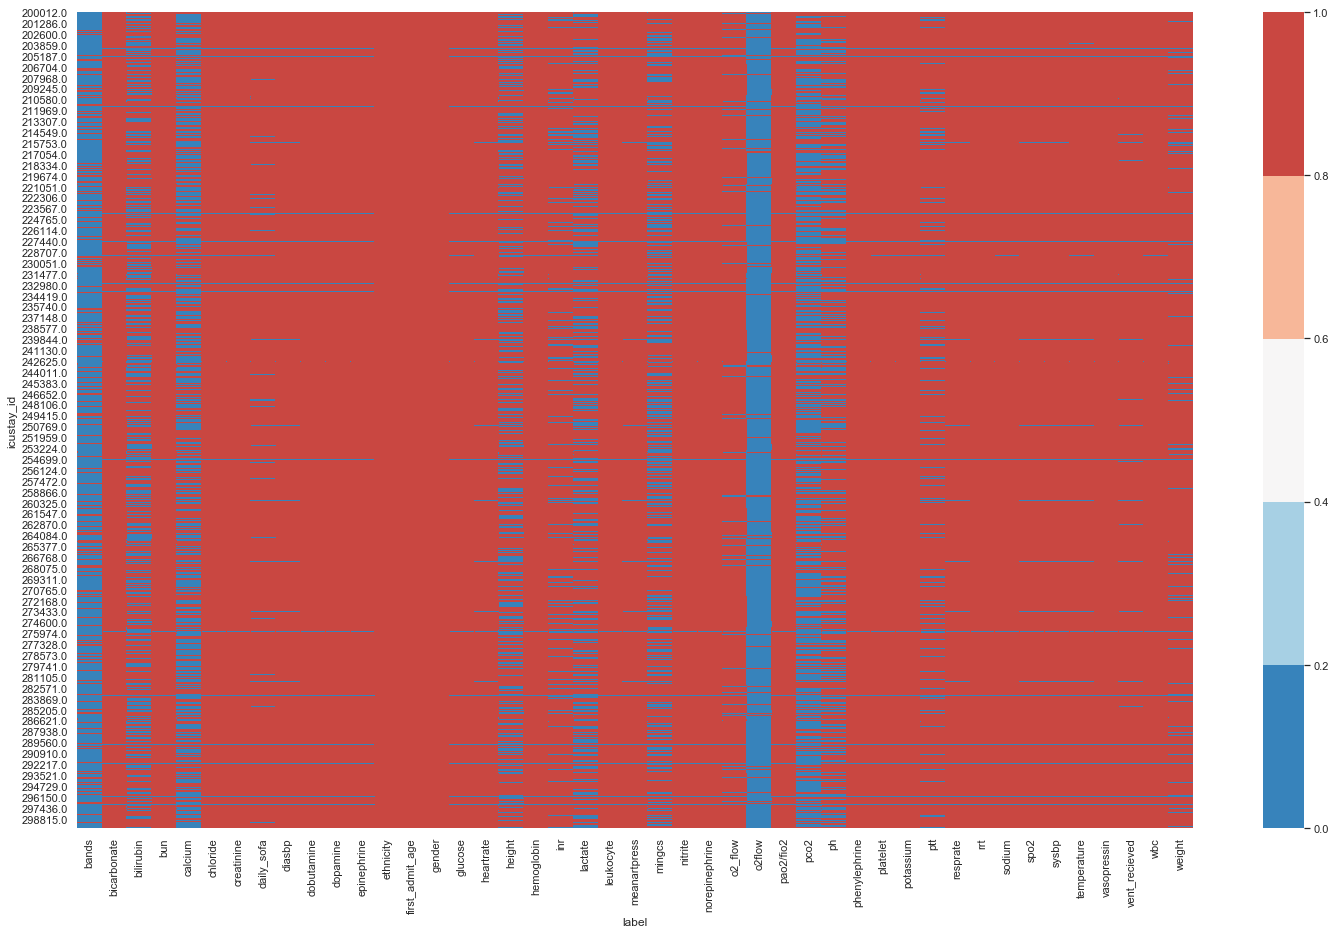

time: 2.45 s


In [59]:
#big_agg_min

#%matplotlib inline
sns.set(rc={'figure.figsize':(25,15)})
big_agg_count= big_agg_count.fillna(0)
big_agg_count = big_agg_count[big_agg_count.columns].astype(float) 


sns.heatmap(big_agg_count,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

In [60]:
###f

time: 511 µs


In [61]:
len(list(big_agg_count)) #38 columns. 

45

time: 2.27 ms


In [62]:
big_agg_count

label,bands,bicarbonate,bilirubin,bun,calcium,chloride,creatinine,daily_sofa,diasbp,dobutamine,...,resprate,rrt,sodium,spo2,sysbp,temperature,vasopressin,vent_recieved,wbc,weight
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,20.0,2.0,...,22.0,2.0,0.0,22.0,20.0,6.0,2.0,1.0,2.0,2.0
200014.0,0.0,6.0,0.0,6.0,6.0,6.0,6.0,2.0,96.0,2.0,...,100.0,2.0,6.0,92.0,98.0,60.0,2.0,1.0,6.0,2.0
200019.0,0.0,4.0,0.0,4.0,0.0,4.0,4.0,5.0,96.0,2.0,...,107.0,2.0,4.0,105.0,92.0,19.0,2.0,1.0,4.0,2.0
200030.0,1.0,11.0,1.0,10.0,3.0,11.0,10.0,8.0,170.0,20.0,...,155.0,2.0,11.0,156.0,171.0,57.0,2.0,1.0,8.0,2.0
200033.0,0.0,14.0,0.0,14.0,4.0,22.0,14.0,8.0,163.0,2.0,...,167.0,2.0,24.0,151.0,163.0,45.0,2.0,1.0,6.0,2.0
200036.0,0.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,106.0,2.0,...,132.0,2.0,5.0,124.0,106.0,29.0,2.0,1.0,5.0,2.0
200055.0,0.0,4.0,1.0,4.0,1.0,5.0,4.0,4.0,51.0,2.0,...,57.0,2.0,5.0,57.0,53.0,11.0,2.0,1.0,4.0,2.0
200059.0,0.0,17.0,2.0,16.0,20.0,21.0,16.0,8.0,330.0,2.0,...,272.0,2.0,21.0,198.0,342.0,137.0,2.0,1.0,18.0,2.0
200061.0,0.0,6.0,6.0,6.0,0.0,6.0,6.0,4.0,75.0,2.0,...,75.0,2.0,6.0,75.0,75.0,21.0,2.0,1.0,6.0,2.0


time: 73.9 ms


In [63]:
big_agg_count[big_agg_count>0] =1
big_agg_pt_missing= big_agg_count.T.apply(lambda x:100*(len(list(big_agg_count))-sum(x))/len(list(big_agg_count)))
big_agg_pt_missing= pd.DataFrame(big_agg_pt_missing).rename(index=str, columns={0:'%_of_values_missing'})

time: 952 ms


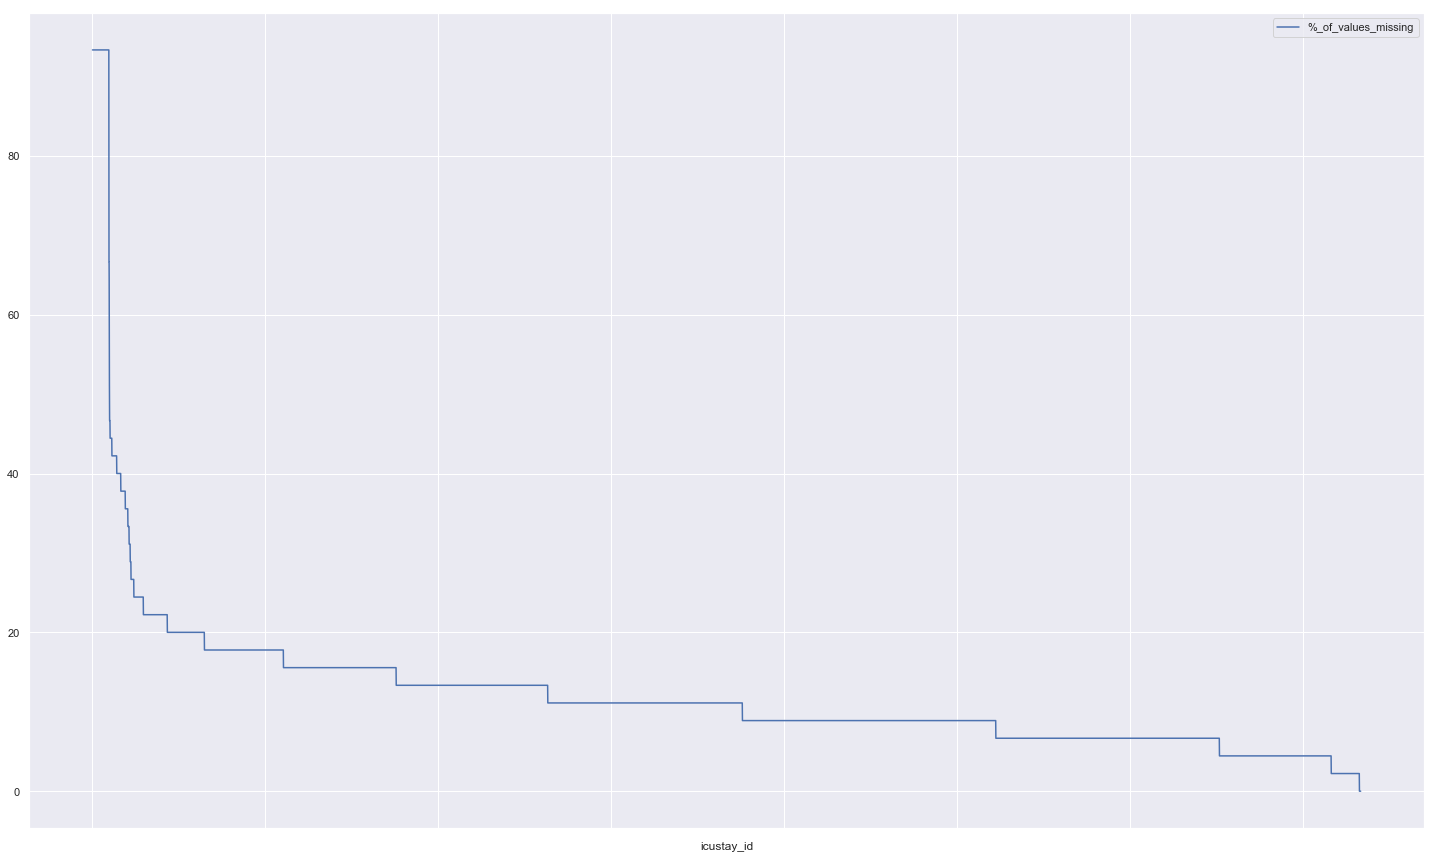

time: 304 ms


In [64]:
big_agg_pt_missing.sort_values('%_of_values_missing',ascending=False).plot()

In [65]:
len(big_agg_pt_missing)

14668

time: 2.17 ms


In [66]:
big_agg_pt_missing.describe()

,%_of_values_missing
count,14668.000000
mean,12.323728
std,11.065920
min,0.000000
25%,6.666667
50%,11.111111
75%,13.333333
max,93.333333


time: 20.8 ms


# 04-08-19: need to visualize current data. need to see matrix of patient by time. 

see 07.X-PatientTime for this

In [67]:
# list1=[]
# list2=[]
# for element in df_list:
#     if 'value' in (list(dfs[element])):
#         list1.append(element)
#     if 'valuenum' in (list(dfs[element])):
#         list2.append(element)




time: 2.55 ms


In [68]:
# for element in list2:
#     print(dfs[element].groupby('label')['valuenum'].describe())

time: 612 µs


In [69]:
# for element in list1:
#     print(dfs[element].groupby('label')['value'].describe())

time: 2.66 ms


In [70]:
# dfs['bg_ART'].groupby('label')['valuenum'].apply(lambda x: type(x))

time: 815 µs
